In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from nbdev.showdoc import *

In [56]:
#| hide
from RSNA__Breast_Cancer_Detection.core import * 
from RSNA__Breast_Cancer_Detection.small_dataset_creation import * 


# RSNA-_Breast_Cancer_Detection

> RSNA Breast cancer detection competition analysis will be done here

This file will become your README and also the index of your documentation.

## Install

```sh
pip install RSNA__Breast_Cancer_Detection
```

## How to use

### Small dataset creation: why?

- The problem is that, with all the images it takes almost 1 hour for each epoc
- Therefore need a subset of data for faster experimentation.
- Possitive image number is very less. So I tried to create the same distribution of in the newer smaller dataaset


### Small dataset creation: how?

- Split the data stratified way and take desired amount into training data
- Then use those training data
- We can create symbolic link to those subset of the data.

In [52]:
from pathlib import Path
import pandas as pd
import numpy as np
from fastai.vision.all import *

In [53]:
data_path = Path.cwd().parent/'data'/'bc_768_roi'
data_train_path = Path(data_path/'train')
data_test_path = Path(data_path/'test')
data_symlink_path = Path(r'/home/hasan/workspace/data/symlink/')
df_train = pd.read_csv(data_path/'train.csv.zip')
df_test = pd.read_csv(data_path/'test.csv')

In [54]:
df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [10]:
df_t = process_trn_df(df_train)
df_t.head()

,image_name,cancer
0,10006_462822612.png,0
1,10006_1459541791.png,0
2,10006_1864590858.png,0
3,10006_1874946579.png,0
4,10011_220375232.png,0


In [12]:

strY = StratifyYSplitData(
                        X='image_name', 
                        Y='cancer',
                        df_t=df_t,
                        train_path=data_train_path,
                        test_size=0.9)

(xtrn, ytrn), (xval, yval) = strY.get_data()

print(f' Training size = {len(xtrn)},  and validation size = {len(xval)}')


 Training size = 5470,  and validation size = 49236


- Now create symbolic link to a folder with only this 5470 images

In [14]:
create_small_dataset(
                    destination_=data_symlink_path,
                    image_list=xtrn,
                    symlink_=True)

Creating symbolic link of 5470 images in /home/hasan/workspace/data/symlink
 number of files found in /home/hasan/workspace/data/symlink == 5470


In [16]:
fn = get_image_files(data_symlink_path)

- Based on image name we need the label of subsequent images

In [17]:

trn_dict = strY.get_label_dict(
                               data_list='small',
                               image_list=fn)

In [18]:
trn_dict

{'30327_282752780.png': 0,
 '4924_332703934.png': 0,
 '42747_1751140002.png': 0,
 '54980_2002547124.png': 0,
 '57680_52336442.png': 0,
 '58069_1048934956.png': 0,
 '10011_220375232.png': 0,
 '4115_900722943.png': 0,
 '37510_1125771757.png': 0,
 '55249_1459512180.png': 0,
 '13256_657470934.png': 0,
 '41584_784731834.png': 0,
 '58168_1277856808.png': 0,
 '6590_2000707656.png': 0,
 '58906_1851980995.png': 0,
 '55116_2088273698.png': 0,
 '52012_1550487859.png': 0,
 '46124_1647466399.png': 0,
 '26965_173743477.png': 0,
 '33647_891228696.png': 0,
 '17407_842697038.png': 0,
 '55335_1788738342.png': 0,
 '26185_1971298674.png': 0,
 '15173_2129624413.png': 0,
 '4049_810506537.png': 0,
 '5645_302172273.png': 0,
 '58346_29494406.png': 0,
 '25253_1599411245.png': 0,
 '62963_1389872397.png': 0,
 '55822_1905286797.png': 0,
 '63706_1241091399.png': 1,
 '11394_519343164.png': 0,
 '3053_1035162651.png': 0,
 '64152_788650096.png': 0,
 '59704_1118223910.png': 0,
 '6022_178374736.png': 0,
 '50570_605426107

In [19]:
def label_func(x):
    return trn_dict[x.name]  

In [20]:
dls_ff = ImageDataLoaders.from_path_func(
                                      data_symlink_path,
                                      fnames=fn,
                                      label_func=label_func,
                                      item_tfms=Resize(166, method='squish'),
                                      batch_tfms=aug_transforms(size=128, min_scale=.75),
                                 
                                      valid_pct=0.2,
                                      seed=42,
                                      )
dls_ff.device = default_device()

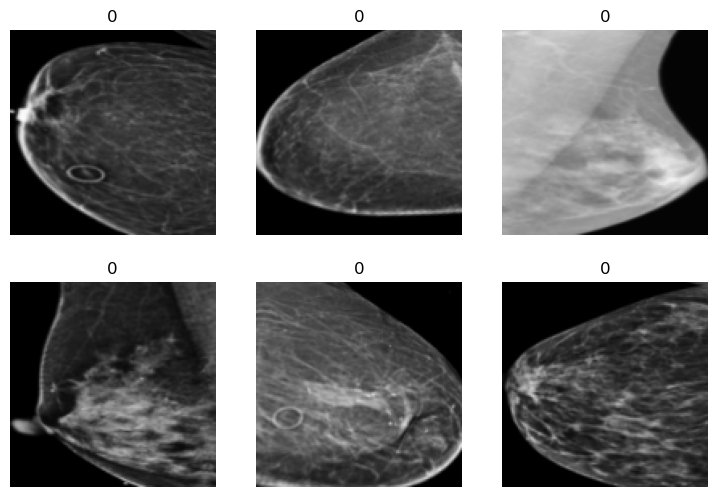

In [21]:
dls_ff.show_batch(max_n=6)

SuggestedLRs(valley=0.007585775572806597, slide=0.02290867641568184)

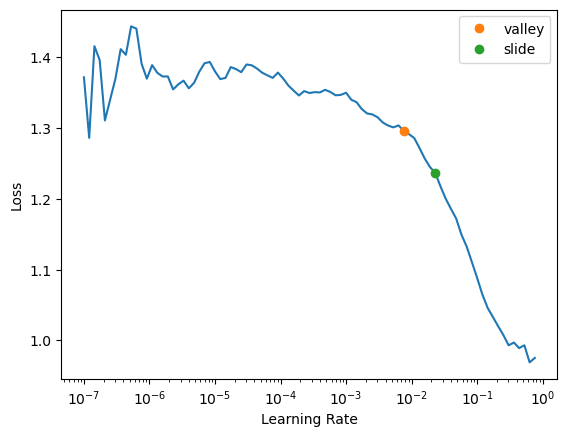

In [22]:
learn = vision_learner(dls_ff, 'resnet26d', metrics=error_rate, path='.').to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

In [23]:
learn.fine_tune(3, 0.02)

epoch,train_loss,valid_loss,error_rate,time
0,0.462719,0.162419,0.023766,01:52


epoch,train_loss,valid_loss,error_rate,time
0,0.184995,0.197379,0.019196,00:48
1,0.157783,0.142290,0.020110,01:08
2,0.119320,0.121825,0.019196,01:15


In [32]:
data_test_path

Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/test')

In [33]:
tst_files = get_image_files(data_test_path).sorted()
tst_files

(#4) [Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/test/10008_1591370361.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/test/10008_361203119.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/test/10008_68070693.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/test/10008_736471439.png')]

In [34]:

tst_dl = dls_ff.test_dl(tst_files)

In [72]:
#show_doc(learn.get_preds)

In [63]:
probs,_,idxs = learn.get_preds(
                   dl=tst_dl,
                   with_decoded=True)

In [74]:
dls_ff.vocab

[0, 1]

In [67]:
probs[:,1]

TensorBase([0.0078, 0.0259, 0.0143, 0.0140])

In [73]:
idxs

TensorBase([0, 0, 0, 0])

In [48]:
df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [43]:
mapping = dict(enumerate(dls_ff.vocab))
results = pd.Series(probs[:,1].numpy(), name="idxs")
results

0    0.007756
1    0.025859
2    0.014268
3    0.013983
Name: idxs, dtype: float32

In [37]:
ss = pd.read_csv(data_path/'sample_submission.csv')
ss.head()

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [ ]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

In [44]:
ss.to_csv('subm.csv', index=False)

In [46]:
comp = 'rnsa-breast-cancer-detection'
from kaggle import api
api.competition_submit_cli('subm.csv', 'first sub', comp)

ProtocolError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
MODEL_PATH = '/kaggle/input/rsna-trained-model-weights/